<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/pulsar_pca_xgb_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 15th June, 2023

## Basics

In [12]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Call libraries

In [13]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA


# 1.02
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.05
import shutil
from pathlib import Path
import itertools

In [14]:
# 1.06
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### Read data

In [15]:
# 2.0 Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/pulsar_data_train.csv")
data.head(3)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


In [16]:
# 2.0.1

data.shape      # (12528, 8)
print("\n===\n")
data.dtypes

(12528, 9)


===



 Mean of the integrated profile                  float64
 Standard deviation of the integrated profile    float64
 Excess kurtosis of the integrated profile       float64
 Skewness of the integrated profile              float64
 Mean of the DM-SNR curve                        float64
 Standard deviation of the DM-SNR curve          float64
 Excess kurtosis of the DM-SNR curve             float64
 Skewness of the DM-SNR curve                    float64
target_class                                     float64
dtype: object

In [17]:
# 2.1 Check nulls
#     We will need to impute it:

data.isnull().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

In [18]:
# 2.2 Rename columns with spaces:

data = data.rename(columns = { " Mean of the integrated profile" : "MIP",
                               " Standard deviation of the integrated profile" : "StdDevIP",
                               " Excess kurtosis of the integrated profile" : "ExKurtosisIP",
                               " Skewness of the integrated profile" : "SkewIP",
                               " Mean of the DM-SNR curve" : "MeanDMSNR",
                               " Standard deviation of the DM-SNR curve" : "StdDevDMSNR",
                               " Excess kurtosis of the DM-SNR curve" : "ExKurtosisDMSNR",
                               " Skewness of the DM-SNR curve" : "SkewDMSNR",
                               "target_class" : "target"
                             }

                   )

# 2.2.1
data.head(3)


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


In [19]:
# 2.2 Rename columns with spaces:

data = data.rename(columns = { " Mean of the integrated profile" : "Mean_integrated_profile",
                               " Standard deviation of the integrated profile" : "Std_dev_integrated_profile",
                               " Excess kurtosis of the integrated profile" : "Excesskurtosis_integrated_profile",
                               " Skewness of the integrated profile" : "Skewness_integrated_profile",
                               " Mean of the DM-SNR curve" : "Mean_DM_SNR_curve",
                               " Standard deviation of the DM-SNR curve" : "Std_dev_DM_SNR_curve",
                               " Excess kurtosis of the DM-SNR curve" : "ExcessKurtosis_DM_SNR_curve",
                               " Skewness of the DM-SNR curve" : "SkewnessDM_SNR_curve"
                             }

                   )

# 2.2.1
data.head(3)


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


### Histogram and boxplots of features

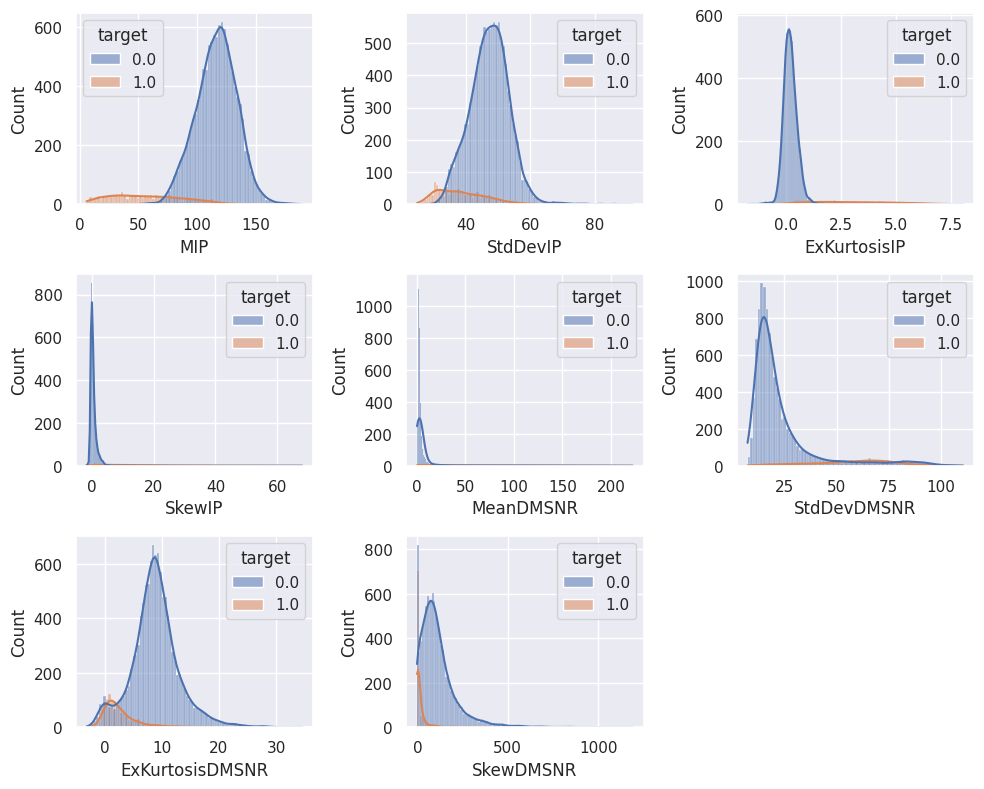

In [20]:
# 2.3 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

sns.set_theme()
pos = 1
fig = plt.figure(figsize=(10,18));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=sns.histplot(data = data, x = i,ax=ax, hue = 'target', kde = 'True');
    plt.tight_layout();

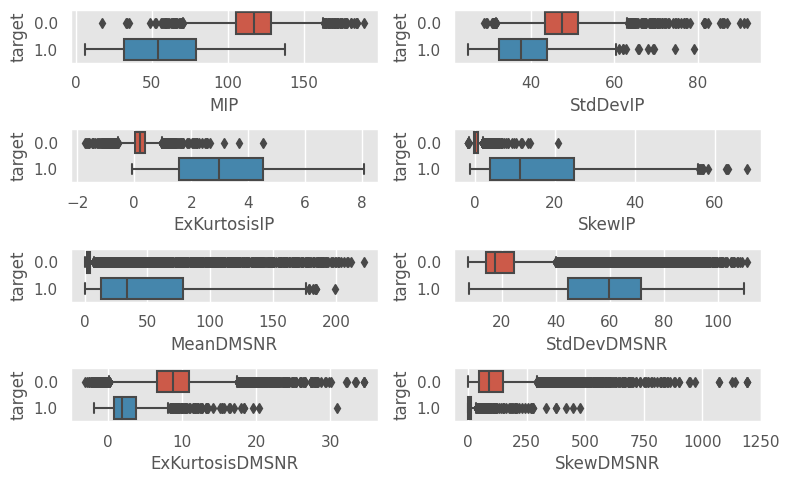

In [21]:
# 2.4 Lets look at how features are related to target:

plt.style.use("ggplot")
df = data.copy()
df['target'] = df['target'].astype("string")
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target')
    plt.tight_layout();

del(df)

In [22]:
# 2.5 Pop out target and check
#       proportions of classes

y = data.pop("target")

# 2.0.2 Imbalanced data:
y.value_counts(normalize = True)

0.0    0.907966
1.0    0.092034
Name: target, dtype: float64

## Transform numeric data to categorical

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand.

In [23]:
# 3.0 How many unique values exist per column?
#     So 30 bins per column should not be excessive:

for i in data.columns[:-1]:
  print(f"No of unique values in {i}:  \t {data[i].nunique()}")

No of unique values in MIP:  	 7192
No of unique values in StdDevIP:  	 12510
No of unique values in ExKurtosisIP:  	 10793
No of unique values in SkewIP:  	 12528
No of unique values in MeanDMSNR:  	 7224
No of unique values in StdDevDMSNR:  	 11348
No of unique values in ExKurtosisDMSNR:  	 12526


In [24]:
# 3.0.1 Discretise all features of data. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                                 y,
                                                                                 bins = 30,
                                                                                 test_size = 0.1,
                                                                                 genColName = False  # Keep orig col names
                                                                                )

In [25]:
# 3.0.2 Check  original data:

orig_train.shape   # (11276, 9)
orig_train.head(3)
orig_test.head(3)
orig_test.shape   # (1252, 9)


(11276, 9)

,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
11530,78.460938,37.632246,0.761066,2.516426,2.241639,17.166000,8.768599,85.693532,0.0
4912,137.500000,37.165172,NaN,1.245371,3.239130,25.127128,8.179860,68.019792,0.0
9368,104.585938,48.763704,1.217617,1.745403,43.056856,68.276894,1.392848,0.564216,0.0


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
2837,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
7177,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
10401,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


(1252, 9)

In [26]:
# 3.0.3 Check discretised features
#       train/test in binned data and original
#       split data have the same row-indicies:

train_binned.shape     # (11276, 9)
train_binned.head(3)
test_binned.head(3)
test_binned.shape      # (1252, 9)

(11276, 9)

,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
11530,412,86,128,162,201,243,2810,323,0.0
4912,422,86,NaN,162,201,246,2810,322,0.0
9368,417,811,1210,162,206,2418,284,321,0.0


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
2837,419,811,127,161,201,244,289,322,0.0
7177,412,86,128,163,201,243,2810,323,0.0
10401,421,813,126,161,201,245,2810,322,0.0


(1252, 9)

In [27]:
# 3.0.4 No of unique values in train_binned
#       Less than 30 (no of bins) in a feature
#       would cause NaN values in test_binned
#       when transformed to numeric:

for i in train_binned.columns[:-1]:
  print(f"No of unique values in feature {i} are \t {train_binned[i].nunique()}")

No of unique values in feature MIP are 	 30
No of unique values in feature StdDevIP are 	 28
No of unique values in feature ExKurtosisIP are 	 30
No of unique values in feature SkewIP are 	 29
No of unique values in feature MeanDMSNR are 	 30
No of unique values in feature StdDevDMSNR are 	 30
No of unique values in feature ExKurtosisDMSNR are 	 30
No of unique values in feature SkewDMSNR are 	 28


### Impute data: Learn using train data:

In [28]:
# 4.1 Impute original data
#     strategy: 'median'

si = SimpleImputer(strategy = 'median')
orig_train[:] = si.fit_transform(orig_train)
orig_test[:] = si.transform(orig_test)

In [29]:
# 4.2 Impute binned data:
#     strategy: 'most_frequent'

si = SimpleImputer(strategy = 'most_frequent')
train_binned[:] = si.fit_transform(train_binned)
test_binned[:] = si.transform(test_binned)

In [30]:
# 4.3 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [31]:
## 5.0 Developing models
#      Decide our cat_cols

if 'target' not in train_binned.columns:
  cat_cols = list(train_binned.columns)  # All columns
  # Keep interacting columns, same
  # as cat columns:
  interactingCatCols = cat_cols  # alternative: []

len(cat_cols)  # 8



8

In [32]:
# 5.1 Instantiate CustomTransformer class:
ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,0,0],  # This is better than all 1s
                       saveGraph = True  # Save graph files also
                                         # By default saved to /<currentFolder>/allmodels/models/
                       )

# 5.1.1 Fit it on train data:
ct.fit(train_binned, cat_cols, interactingCatCols)


Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('MIP', 'StdDevIP', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'ExKurtosisIP', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'SkewIP', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'MeanDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'StdDevDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'ExKurtosisDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'SkewDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'SkewIP_p_StdDevDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'ExKurtosisIP_p_SkewDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'ExKurtosisIP_p_MeanDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'ExKurtosisDMSNR_p_SkewDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'StdDevIP_p_SkewIP', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'MIP_p_ExKurtosisIP', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'StdDevDMSNR_p_ExKurtosisDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'MIP_p_MeanDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'StdDevIP_p_ExKurtosisIP'

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 0, 0],
                  modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation

In [33]:
# 6.0 Transform both 'test_binned' and 'train_binned' data:
#     Takes time....

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1120
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 8.784032 MB
Mem usage after dtype transformation is: 4.437088 MB


'Transformed test data shape: (1252, 876)'

In [34]:
# 6.0.1 Transform train_binned now:
#       Takes time....

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1120
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 79.112416 MB
Mem usage after dtype transformation is: 39.962144 MB


'Transformed train data shape: (11276, 876)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [35]:
# 6.1 Observe data now:
#     It also has original binned cols (10):

train_trans.head()
test_trans.head()

,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,deg_MIP_ck_StdDevIP,eig_MIP_ck_StdDevIP,...,pr_SkewDMSNR_ck_SkewIP_p_MeanDMSNR,clu_SkewDMSNR_ck_SkewIP_p_MeanDMSNR,deg_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,eig_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,pr_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,clu_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,deg_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,eig_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,pr_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,clu_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR
0,412,86,128,162,201,243,2810,323,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.941520,0.185185,0.147612,0.032445,0.800000
1,422,86,126,162,201,246,2810,322,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.941520,0.111111,0.101621,0.021618,1.000000
2,417,811,1210,162,206,2418,284,321,1.0,0.185046,...,0.036558,0.97151,1.000000,0.226934,0.046330,0.740741,0.777778,0.481320,0.120603,0.233333
3,421,812,126,161,201,245,289,322,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.941520,0.111111,0.101621,0.021618,1.000000
4,417,86,127,162,201,242,2811,324,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.941520,0.222222,0.173638,0.037604,0.733333


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,deg_MIP_ck_StdDevIP,eig_MIP_ck_StdDevIP,...,pr_SkewDMSNR_ck_SkewIP_p_MeanDMSNR,clu_SkewDMSNR_ck_SkewIP_p_MeanDMSNR,deg_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,eig_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,pr_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,clu_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,deg_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,eig_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,pr_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,clu_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR
0,419,811,127,161,201,244,289,322,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.941520,0.111111,0.101621,0.021618,1.000000
1,412,86,128,163,201,243,2810,323,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.941520,0.185185,0.147612,0.032445,0.800000
2,421,813,126,161,201,245,2810,322,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.941520,0.111111,0.101621,0.021618,1.000000
3,425,811,125,161,203,243,285,321,1.0,0.185046,...,0.036558,0.97151,1.000000,0.226934,0.046330,0.740741,0.777778,0.481320,0.120603,0.233333
4,413,86,128,163,201,244,2810,322,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.941520,0.111111,0.101621,0.021618,1.000000


## Make an archive of files in gdrive
This is for later use


In [36]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### Archive of graph files to gdrive

In [40]:
# 6.2.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/allmodels/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [41]:
# 6.3 Archive folder where graph files are stored to gdrive
output_filename = outputfolder / "models"
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(output_filename) +".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/allmodels/models.zip'

In [42]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = Path(r'/gdrive/MyDrive/Colab_data_files/allmodels/models').glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/StdDevDMSNR_bigraph_StdDevIP_p_ExKurtosisDMSNR.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/MIP_bigraph_MIP_p_StdDevIP.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExKurtosisIP_projected_StdDevDMSNR.gml')]

### Archive of datafiles

In [43]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


train_binned['target'] = ytr
test_binned['target'] = yte

destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)

trfile = destination / "train_binned.pkl"
tefile = destination / "test_binned.pkl"
ortrfile = destination / "orig_train.pkl"
ortefile = destination / "orig_test.pkl"
tr_trans = destination / "train_trans.pkl"
te_trans = destination / "test_trans.pkl"

train_binned.to_pickle(trfile)
test_binned.to_pickle(tefile)
orig_train.to_pickle(ortrfile)
orig_test.to_pickle(ortefile)
train_trans.to_pickle(tr_trans)
test_trans.to_pickle(te_trans)

In [44]:
# 6.5.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/datafiles/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [45]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
output_filename = outputfolder / "data"
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )



# 6.6 Unpack the zipped file now:
shutil.unpack_archive(str(output_filename)+".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/datafiles/data.zip'

In [46]:
# 6.7 Let us have a look at our list of pickled files:
p = Path(r'/gdrive/MyDrive/Colab_data_files/datafiles/data').glob('**/*')
files = [x for x in p if x.is_file()]
files

[PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/train_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/train_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/test_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/test_binned.pkl')]

In [47]:
# 6.8 Pop out target:
#     It is already popped out

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCAs with original data and with transformed data:
We perform PCA of transformed data with all features. We latter perform PCA again but only with important features.

In [48]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape  # (11276, 2)

(11276, 2)

In [49]:
# 7.1 PCA with transformed train data.
#     Drop all cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape  # (11276, 2)

(11276, 2)

In [50]:
# 7.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

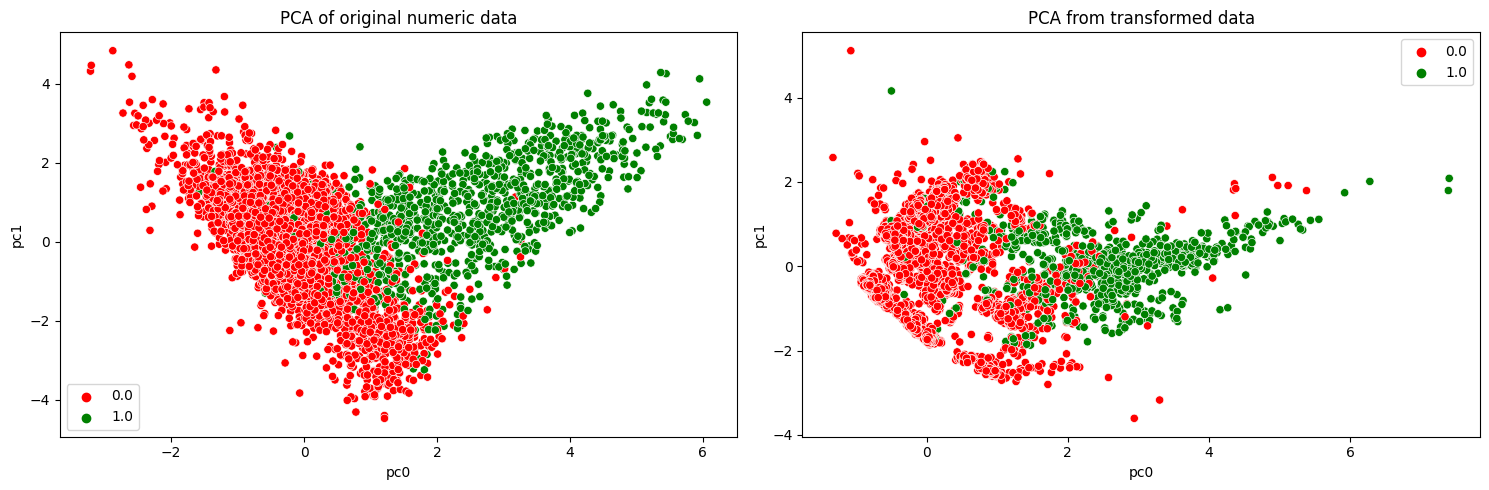

In [52]:
# 8.0 2D PCA plot from original train data:

plt.style.use("default")
fig = plt.figure(figsize = (15,5));
fig.add_subplot(1,2,1);
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA of original numeric data');

# 8.1 2D PCA plot from transformed train data:

fig.add_subplot(1,2,2);
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

plt.tight_layout();

##xgboost modeling of original features and of transformed features


In [53]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 700,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 6,
                               subsample = 0.8,
                               random_state = None,
                              )

# 9.0.1
tr_X =   orig_train
test_X = orig_test
ytr = ytr
yte = yte

# 9.0.2
model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 100,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )

[13:07:43] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[13:07:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.95023	validation_1-auc:0.94589
[13:07:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.97006	validation_1-auc:0.96251
[13:07:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.96945	validation_1-auc:0.96002
[13:07:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.96979	validation_1-auc:0.95983
[13:07:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.96904	validation_1-auc:0.95925
[13:07:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [54]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9752221339305064'

'Best iteration from orig train/test data: 216'

In [55]:
# 9.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 600,
                                  verbosity = 3,
                                  eta = 0.06,
                                  max_depth = 14,
                                  subsample = 0.8,
                                  random_state = None,
                           )

# 9.2.1
tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr
yte = yte

# 9.2.2
model_trans.fit(tr_X, ytr.values,
          early_stopping_rounds = 100,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[13:07:58] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[13:07:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation_0-auc:0.94986	validation_1-auc:0.93945
[13:08:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.96601	validation_1-auc:0.94487
[13:08:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.97254	validation_1-auc:0.95806
[13:08:04] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation_0-auc:0.97365	validation_1-auc:0.96128
[13:08:04] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=11
[4]	validation_0-auc:0.97550	validation_1-auc:0.96107
[13:08:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned no

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve plots

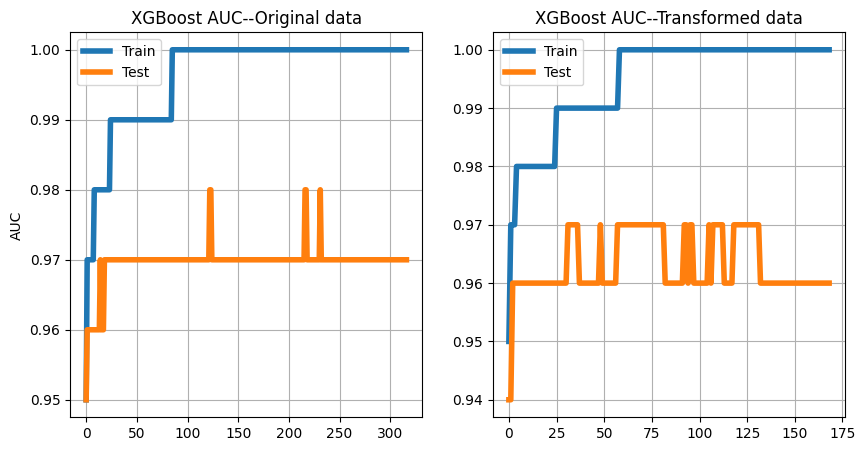

In [58]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5));

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],2),linewidth=4, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],2), linewidth=4, label='Test');
ax[0].legend();
ax[0].grid()
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],2), linewidth=4, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],2), linewidth = 4, label='Test');
ax[1].legend();
ax[1].grid()
ax[1].set_title('XGBoost AUC--Transformed data');
plt.show();

In [59]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.9670671899957459'

'Best iteration from transformed train/test data: 68'

## Feature importance of transformed features:
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>

In [60]:
# 10.0 Get feature importance:

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
clu_SkewIP_ck_StdDevIP_p_MeanDMSNR,0.320418
eig_SkewIP_ck_MIP_p_StdDevIP,0.231124
pr_ExKurtosisIP_ck_MeanDMSNR_p_StdDevDMSNR,0.029308
eig_ExKurtosisIP_ck_MIP,0.007618
deg_ExKurtosisIP_ck_MeanDMSNR_p_StdDevDMSNR,0.007363




== Column-list whose feat impt >0 =======



['clu_SkewIP_ck_StdDevIP_p_MeanDMSNR',
 'eig_SkewIP_ck_MIP_p_StdDevIP',
 'pr_ExKurtosisIP_ck_MeanDMSNR_p_StdDevDMSNR',
 'eig_ExKurtosisIP_ck_MIP',
 'deg_ExKurtosisIP_ck_MeanDMSNR_p_StdDevDMSNR']



===Column-list whose feat impt is 0 =======



['clu_StdDevIP_ck_ExKurtosisIP_p_ExKurtosisDMSNR',
 'eig_MIP_ck_StdDevIP',
 'eig_SkewDMSNR_ck_MIP_p_MeanDMSNR',
 'pr_StdDevIP_ck_ExKurtosisIP_p_StdDevDMSNR',
 'deg_SkewDMSNR_ck_StdDevIP_p_ExKurtosisIP']

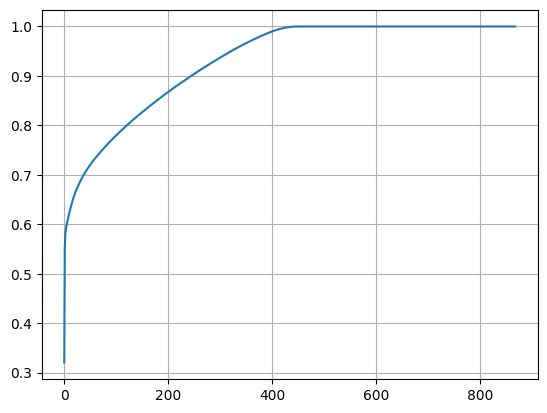

In [61]:
# 10.1 Cumulative sum of feature importance.
#      Last many columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

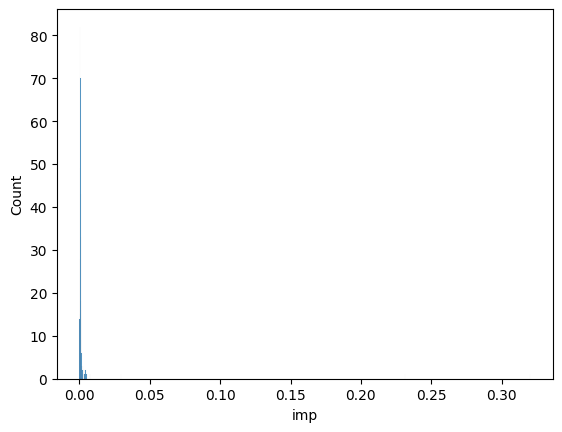

In [62]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt much below 0.01

sns.histplot(fe['imp'][fe_1]);

### XGBoost modeling with impt features

In [63]:
# 11.0 Modeling of transformed train/test data with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 300,
                                      verbosity = 3,
                                      eta = 0.06,
                                      max_depth = 14,
                                      subsample = 0.8,
                                      random_state = None,
                           )

# 11.0.1
tr_X =   train_trans[fe_1[:40]]
test_X = test_trans[fe_1[:40]]
ytr = ytr
yte = yte


# 11.0.2
model_trans_impt.fit(tr_X, ytr.values,
                    early_stopping_rounds = 50,
                    eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                    eval_metric = ['auc']
          )



[13:18:41] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[13:18:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation_0-auc:0.94588	validation_1-auc:0.94174
[13:18:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation_0-auc:0.96875	validation_1-auc:0.96219
[13:18:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.97122	validation_1-auc:0.96154
[13:18:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.97141	validation_1-auc:0.96120
[13:18:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=12
[4]	validation_0-auc:0.97288	validation_1-auc:0.96115
[13:18:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, m

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

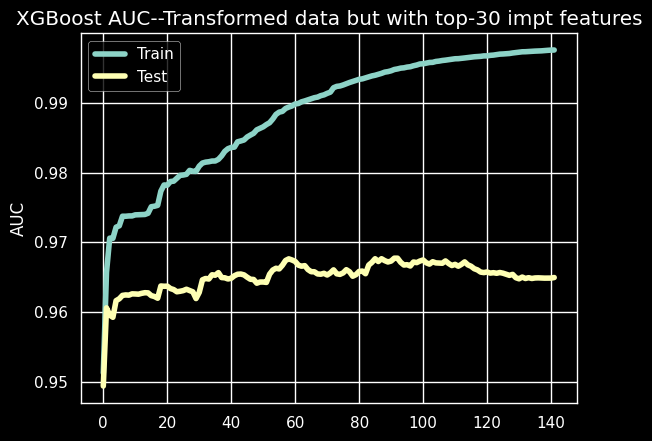

In [ ]:
# 11.1 Learning curve: Modeling with transformed data:
#      We get results better than with all features:

results = model_trans_impt.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], linewidth = 4, label='Train');
ax.plot(x_axis, results['validation_1']['auc'], linewidth = 4, label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data but with top-30 impt features');
plt.show();

## PCAs with impt features of transformed data:
While performing PCA, we only use impt features

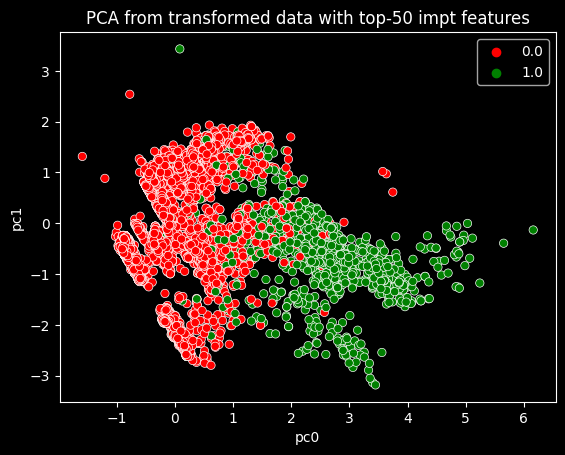

In [65]:
# 12.1 PCA with transformed train data.
#      We keep just the impt features

trans_pca = train_trans[fe_1[:50]] #.iloc[:,len(cat_cols):]
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

# 12.2 PCA plot from transformed data but with impt features:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data with top-50 impt features') ;


## Correlation with orig columns
Correlation of extracted features with original features

In [66]:
# 13.0 Take top five imp features:

tt = train_trans[fe_1[:10]].copy()
tt.shape  # (9000,341)

(11276, 10)

In [67]:
# 13.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows good amount of correlation between the two sets of features

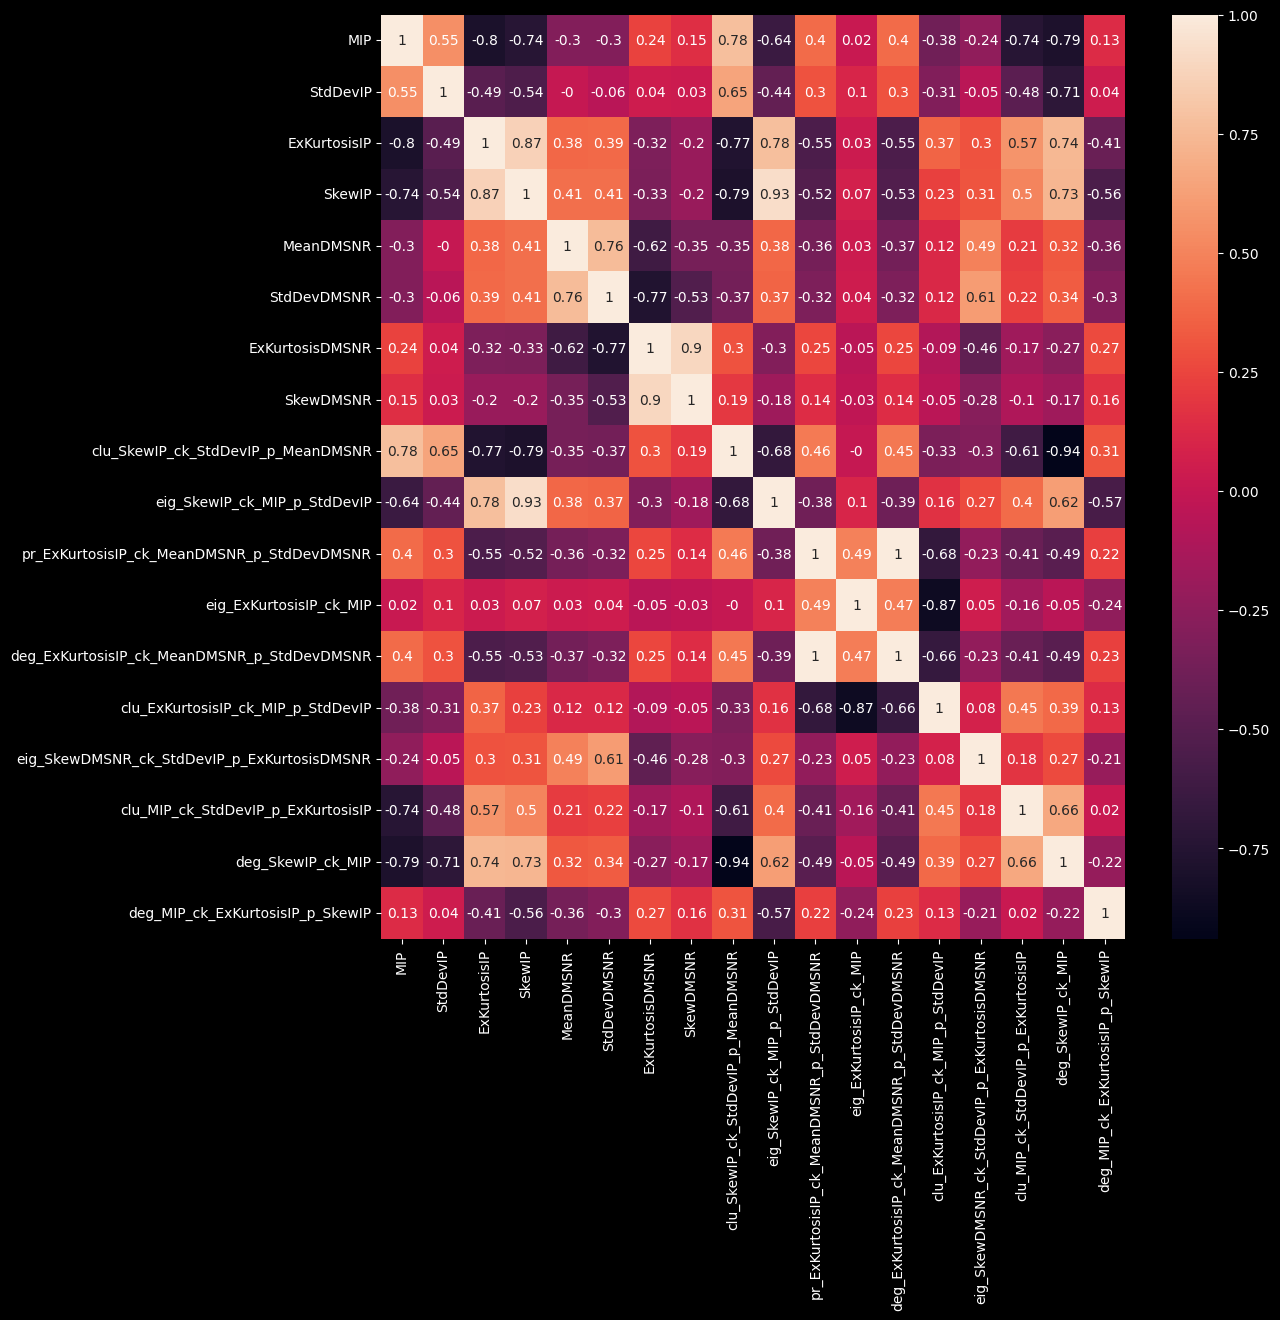

In [68]:
# 13.2 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

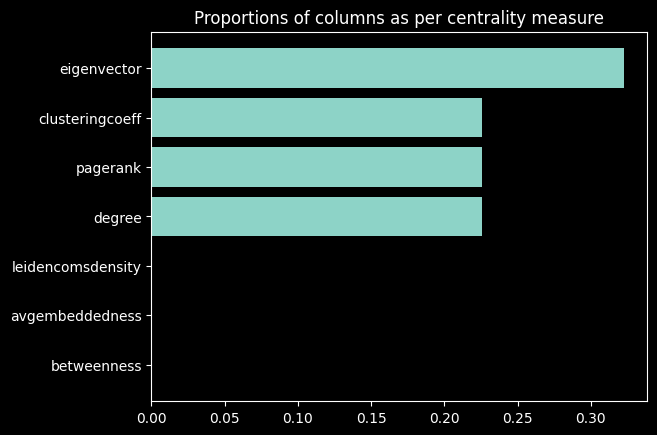

In [69]:
# 14.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [70]:
# 14.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 447'

'Columns whose impt is 0: 421'

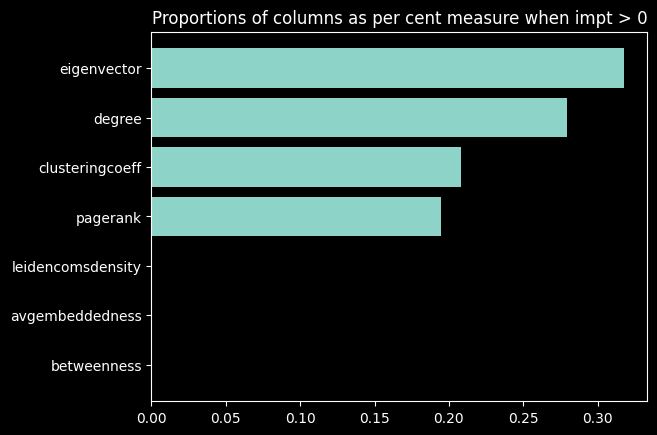

In [71]:
# 14.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [72]:
# 15.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [73]:
# 15.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 15.2 Score of all impt columns:
score[:5]

clu_SkewIP_ck_StdDevIP_p_MeanDMSNR             0.320418
eig_SkewIP_ck_MIP_p_StdDevIP                   0.231124
pr_ExKurtosisIP_ck_MeanDMSNR_p_StdDevDMSNR     0.029308
eig_ExKurtosisIP_ck_MIP                        0.007618
deg_ExKurtosisIP_ck_MeanDMSNR_p_StdDevDMSNR    0.007363
Name: imp, dtype: float32

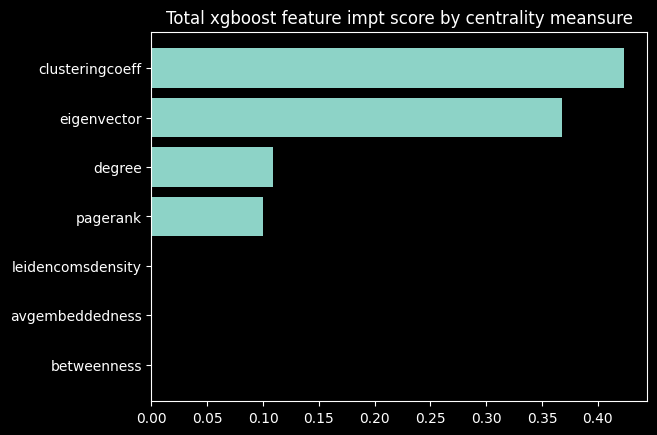

In [74]:
# 15.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs

### Read graph files from gdrive

In [75]:
# 16.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [78]:
# 16.1 Path where .gml files are placed:

pathToFolder = Path("/gdrive/MyDrive/Colab_data_files/allmodels/models")
filelist = sorted(list(pathToFolder.iterdir()))
filelist[:5]   # a_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExKurtosisDMSNR_bigraph_ExKurtosisDMSNR_p_SkewDMSNR.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExKurtosisDMSNR_bigraph_ExKurtosisIP.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExKurtosisDMSNR_bigraph_ExKurtosisIP_p_ExKurtosisDMSNR.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExKurtosisDMSNR_bigraph_ExKurtosisIP_p_MeanDMSNR.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExKurtosisDMSNR_bigraph_ExKurtosisIP_p_SkewDMSNR.gml')]

### Read data files from gdrive:

In [79]:
# 16.2
orig_test = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_test.pkl")
orig_train = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_train.pkl")
train_binned = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/train_binned.pkl")
test_binned = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/test_binned.pkl")
train_trans = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/train_trans.pkl")
test_trans = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/test_trans.pkl")

In [80]:
# 16.3 check data files:
#      All have 'target' col
orig_train.head(2)
orig_test.head(2)
train_binned.head(2)
test_binned.head(2)
train_trans.head(2)
test_trans.head(2)

,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
11530,78.460938,37.632246,0.761066,2.516426,2.241639,17.166000,8.768599,85.693532,0.0
4912,137.500000,37.165172,0.224732,1.245371,3.239130,25.127128,8.179860,68.019792,0.0


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
2837,121.15625,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
7177,76.96875,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
11530,412,86,128,162,201,243,2810,323,0.0
4912,422,86,126,162,201,246,2810,322,0.0


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,target
2837,419,811,127,161,201,244,289,322,0.0
7177,412,86,128,163,201,243,2810,323,0.0


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,deg_MIP_ck_StdDevIP,eig_MIP_ck_StdDevIP,...,pr_SkewDMSNR_ck_SkewIP_p_MeanDMSNR,clu_SkewDMSNR_ck_SkewIP_p_MeanDMSNR,deg_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,eig_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,pr_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,clu_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,deg_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,eig_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,pr_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,clu_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR
0,412,86,128,162,201,243,2810,323,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.94152,0.185185,0.147612,0.032445,0.8
1,422,86,126,162,201,246,2810,322,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.94152,0.111111,0.101621,0.021618,1.0


,MIP,StdDevIP,ExKurtosisIP,SkewIP,MeanDMSNR,StdDevDMSNR,ExKurtosisDMSNR,SkewDMSNR,deg_MIP_ck_StdDevIP,eig_MIP_ck_StdDevIP,...,pr_SkewDMSNR_ck_SkewIP_p_MeanDMSNR,clu_SkewDMSNR_ck_SkewIP_p_MeanDMSNR,deg_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,eig_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,pr_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,clu_SkewDMSNR_ck_StdDevIP_p_StdDevDMSNR,deg_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,eig_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,pr_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR,clu_SkewDMSNR_ck_SkewIP_p_ExKurtosisDMSNR
0,419,811,127,161,201,244,289,322,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.94152,0.111111,0.101621,0.021618,1.0
1,412,86,128,163,201,243,2810,323,1.0,0.185046,...,0.036558,0.97151,0.703704,0.175629,0.033315,0.94152,0.185185,0.147612,0.032445,0.8


### Display graphs--Bigraphs and Projected

In [81]:
# 17.0 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'MIP_projected' in str(i)]

bigraphs = [str(i).split("/")[-1] for i in filelist if 'MIP_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:5]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:5]    # projected graph files

['MIP_bigraph_SkewIP.gml',
 'MIP_bigraph_StdDevIP.gml',
 'MIP_bigraph_MeanDMSNR.gml',
 'MIP_bigraph_SkewDMSNR.gml',
 'MIP_bigraph_StdDevDMSNR.gml']



====



['MIP_projected_SkewIP.gml',
 'MIP_projected_StdDevIP.gml',
 'MIP_projected_MeanDMSNR.gml',
 'MIP_projected_SkewDMSNR.gml',
 'MIP_projected_StdDevDMSNR.gml']

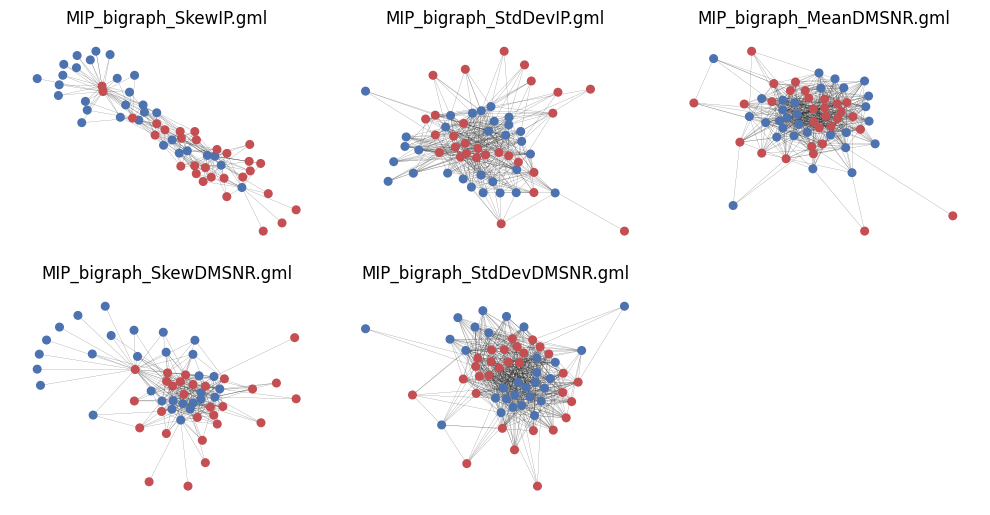

In [83]:
# 17.1 Plot of sample bigraphs:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:5]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _=utils.plotBipartiteGraph(bi,pathToFolder, ax = ax, title = bi, connected = True);
    plt.tight_layout();

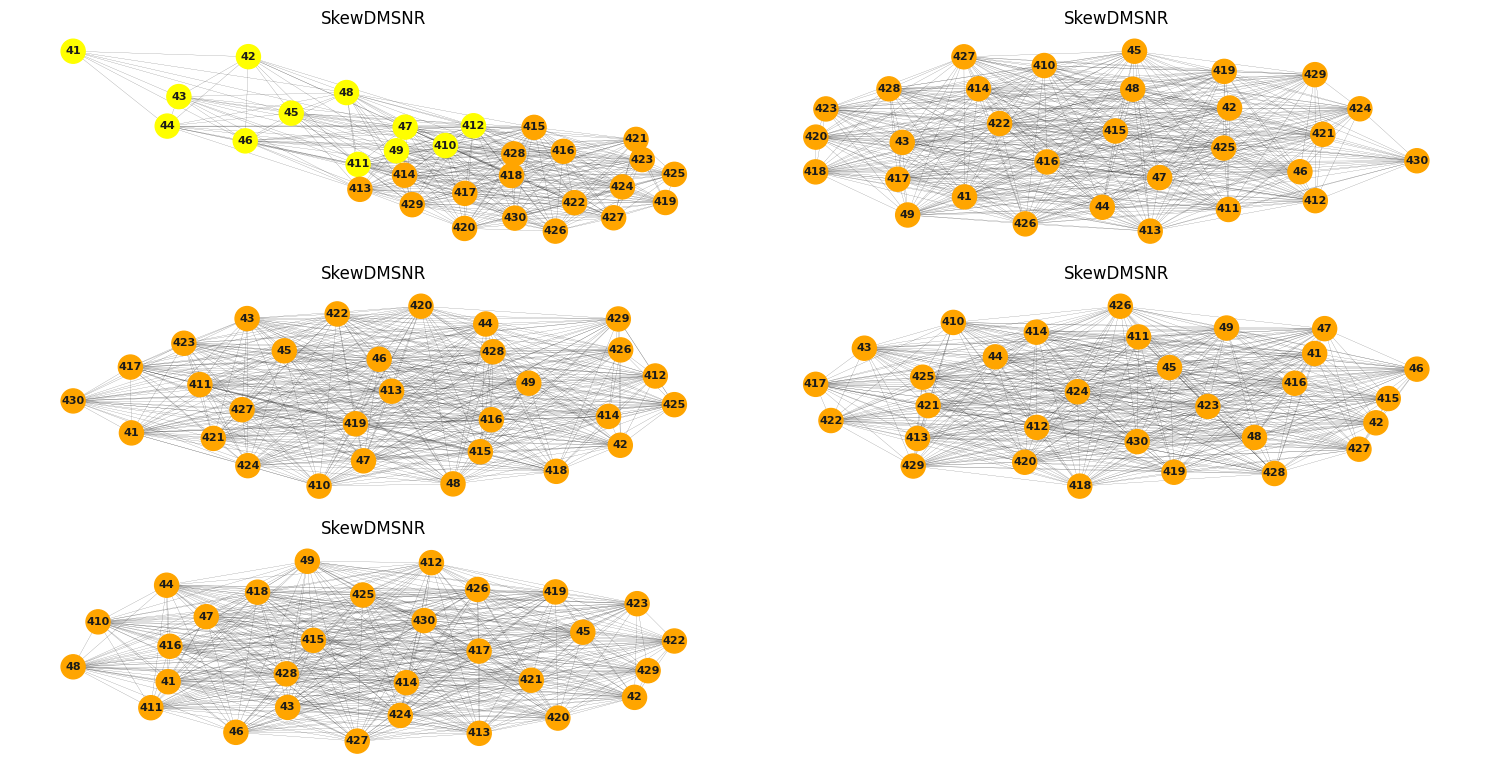

In [84]:
# 17.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:5]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,pathToFolder, ax = ax, withLabels = True, title = i);
    plt.tight_layout();

## Transform binned data to communities:

In [101]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binned cols are:
columnNames = train_binned.columns[:-1]

# 18.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 18.3 Graph files are within:
pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/allmodels/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  _,df_tr = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,train_binned,algo)
  _,df_te = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,test_binned,algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

In [102]:
# 18.5 Observe few rows of transformed data:
fg_tr[0].shape   # (11276, 56)
fg_tr[0].head(5)
fg_te[0].head(5)


(11276, 56)

,MIP_projected_StdDevIP.gml,MIP_projected_ExKurtosisIP.gml,MIP_projected_SkewIP.gml,MIP_projected_MeanDMSNR.gml,MIP_projected_StdDevDMSNR.gml,MIP_projected_ExKurtosisDMSNR.gml,MIP_projected_SkewDMSNR.gml,StdDevIP_projected_MIP.gml,StdDevIP_projected_ExKurtosisIP.gml,StdDevIP_projected_SkewIP.gml,...,ExKurtosisDMSNR_projected_MeanDMSNR.gml,ExKurtosisDMSNR_projected_StdDevDMSNR.gml,ExKurtosisDMSNR_projected_SkewDMSNR.gml,SkewDMSNR_projected_MIP.gml,SkewDMSNR_projected_StdDevIP.gml,SkewDMSNR_projected_ExKurtosisIP.gml,SkewDMSNR_projected_SkewIP.gml,SkewDMSNR_projected_MeanDMSNR.gml,SkewDMSNR_projected_StdDevDMSNR.gml,SkewDMSNR_projected_ExKurtosisDMSNR.gml
11530,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4912,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
9368,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
12423,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
4189,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


,MIP_projected_StdDevIP.gml,MIP_projected_ExKurtosisIP.gml,MIP_projected_SkewIP.gml,MIP_projected_MeanDMSNR.gml,MIP_projected_StdDevDMSNR.gml,MIP_projected_ExKurtosisDMSNR.gml,MIP_projected_SkewDMSNR.gml,StdDevIP_projected_MIP.gml,StdDevIP_projected_ExKurtosisIP.gml,StdDevIP_projected_SkewIP.gml,...,ExKurtosisDMSNR_projected_MeanDMSNR.gml,ExKurtosisDMSNR_projected_StdDevDMSNR.gml,ExKurtosisDMSNR_projected_SkewDMSNR.gml,SkewDMSNR_projected_MIP.gml,SkewDMSNR_projected_StdDevIP.gml,SkewDMSNR_projected_ExKurtosisIP.gml,SkewDMSNR_projected_SkewIP.gml,SkewDMSNR_projected_MeanDMSNR.gml,SkewDMSNR_projected_StdDevDMSNR.gml,SkewDMSNR_projected_ExKurtosisDMSNR.gml
2837,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7177,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10401,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
10766,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2853,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [97]:
# 19.0 Remove constant cols
# https://stackoverflow.com/a/20210048

# Function to remove const columns from DataFrame
def remConstColumns(df):
  print(f"Datashape before processing: {df.shape}")
  df = df.loc[:, (df != df.iloc[0]).any()]
  print(f"Datashape after processing: {df.shape}")
  return df



In [104]:
# 19.0
fg_tr[0] = utils.remConstColumns(fg_tr[0])
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (11276, 56)
Datashape after processing: (11276, 24)


In [107]:
# 19.1 Extract target columns:

ytr = train_binned['target']
yte = test_binned['target']

### xgboost modeling of transformed data:

In [108]:
# 19.2 Modeling with transformed train/test data with community features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 200,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 50,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[13:36:19] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[13:36:19] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.93832	validation_1-auc:0.92605
[13:36:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation_0-auc:0.93847	validation_1-auc:0.92628
[13:36:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.93808	validation_1-auc:0.92626
[13:36:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.93878	validation_1-auc:0.92610
[13:36:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation_0-auc:0.93898	validation_1-auc:0.92651
[13:36:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

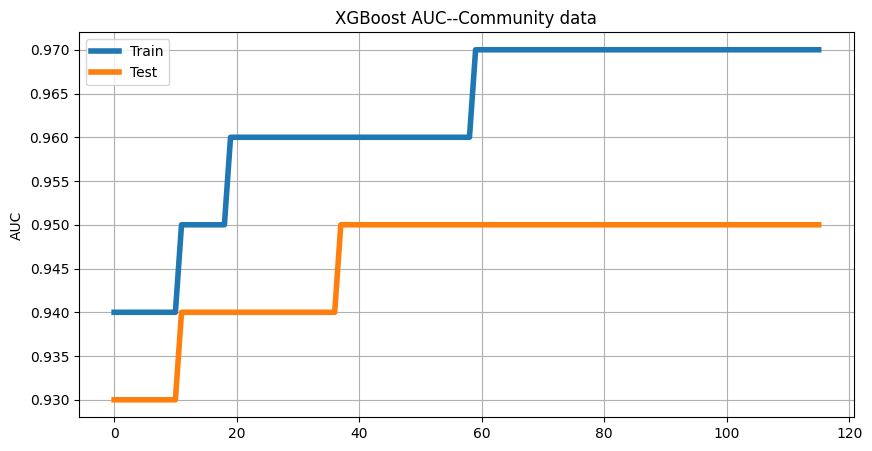

In [109]:
# 19.3 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.figure(figsize = (10,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],2),linewidth=4, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],2), linewidth=4, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Community features");


### PCA of transformed data:

In [111]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

,MIP_projected_ExKurtosisIP.gml,MIP_projected_SkewIP.gml,StdDevIP_projected_MIP.gml,StdDevIP_projected_SkewIP.gml,StdDevIP_projected_MeanDMSNR.gml,ExKurtosisIP_projected_MIP.gml,ExKurtosisIP_projected_StdDevIP.gml,ExKurtosisIP_projected_SkewIP.gml,SkewIP_projected_MIP.gml,SkewIP_projected_StdDevIP.gml,...,StdDevDMSNR_projected_ExKurtosisDMSNR.gml,ExKurtosisDMSNR_projected_MIP.gml,ExKurtosisDMSNR_projected_ExKurtosisIP.gml,ExKurtosisDMSNR_projected_MeanDMSNR.gml,ExKurtosisDMSNR_projected_StdDevDMSNR.gml,ExKurtosisDMSNR_projected_SkewDMSNR.gml,SkewDMSNR_projected_MIP.gml,SkewDMSNR_projected_StdDevIP.gml,SkewDMSNR_projected_StdDevDMSNR.gml,SkewDMSNR_projected_ExKurtosisDMSNR.gml
11530,0,1,0,0,0,1,0,1,1,0,...,1,0,0,0,1,0,0,0,0,1
4912,1,0,0,0,0,1,1,0,1,0,...,1,0,0,0,1,0,1,0,0,1
9368,0,0,0,0,1,1,0,1,1,0,...,0,1,1,1,1,0,0,0,0,1


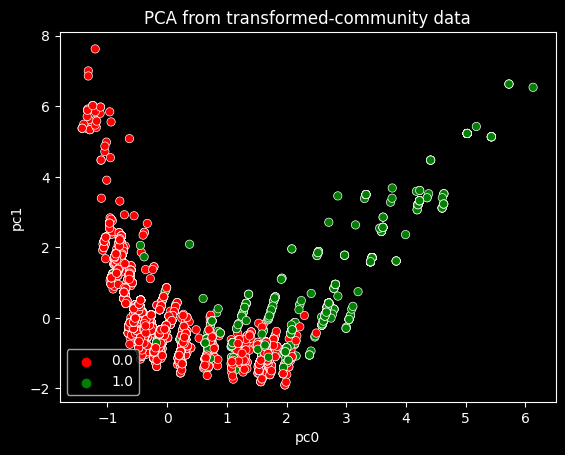

In [112]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))


# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 20.3 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

In [116]:
fg_tr[0] = fg_tr[0].reset_index(drop = True)
fg_te[0] = fg_te[0].reset_index(drop = True)
tr = train_trans[fe_1[:40]].merge(fg_tr[0], left_index = True, right_index = True)
te = test_trans[fe_1[:40]].merge(fg_te[0], left_index = True, right_index = True)

In [ ]:
tr.shape

(11276, 64)

In [ ]:
len(ytr)

11276

In [117]:
# 19.0 Modeling with transformed train/test data with impt features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_jt_commu = xgb.XGBClassifier(  n_estimators= 700,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   tr
test_X = te
ytr = ytr
yte = yte


model_jt_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 900,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[13:45:11] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[13:45:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation_0-auc:0.94589	validation_1-auc:0.94170
[13:45:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation_0-auc:0.96880	validation_1-auc:0.96202
[13:45:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.97121	validation_1-auc:0.96129
[13:45:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.97142	validation_1-auc:0.96105
[13:45:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=12
[4]	validation_0-auc:0.97299	validation_1-auc:0.96107
[13:45:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

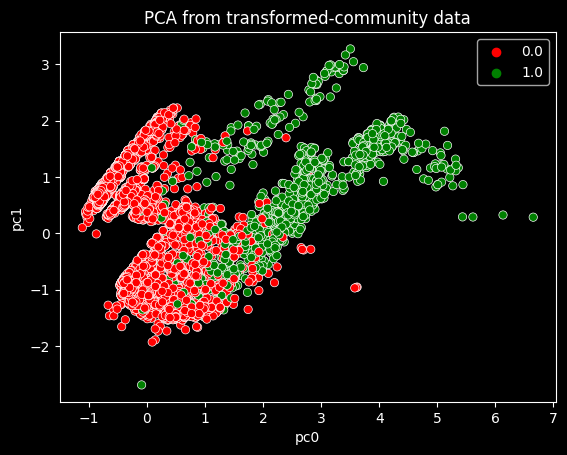

In [118]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(tr))
commu_pca.shape

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 20.3 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

In [ ]:
## OK
def transformBinnedDF2Communities(columnNames,pathToGraphFolder, train_binned, algo):
    """
    Desc
    -----
    Replace every column in the binned the Dataframe as per network community
    Example binned/discrete dataframe:
            'a'     'b
            --      ---
            434     709
            435     789
            23      710
            78      756

    Replace col 'a' as per communities discovered in network 'a_projected_b.gml':
    434 & 435 belong to one community and 23 & 78 to other.

            'a'     'b'
            ---     ---
             0      709
             0      789
             1      710
             1      756

    Similarly, replace col 'b' as per communities in 'b_projected_a.gml':

            'a'     'b'
            ---     ---
             0      1
             0      0
             1      0
             1      1

    Parameters
    -----------
    columnNames: list of cat cols
    pathToGraphFolder: str: Folder that has graph files
    train_binned: DataFrame with binned/discrete columns
    algo: function object: networkx algorithm to be used to
          discover communities.
          Example: nx.community.greedy_modularity_communities

    Returns
    -------
    map_list: list of dictionaries. Each dictionary maps
              levels in a column to a community
    df: DataFrame: Transformed train_binned DataFrame.
        If train_binned had columns other than columnNames,
        df would not contain those columns


    """

    # 1. From col-names names, create graph filenames:
    # Example: col-names: ['a','b','c']
    # First permute col-names in pairs of two:
    #  p = ('a','b'),('b','a'), ('a','c'),('c','a')...
    p = list(itertools.permutations(columnNames,2))
    # Prepare list of graph files:
    # ('a_projected_b.gml', 'b_projected_a.gml'...)
    filelist = []
    for i in p:
      filelist.append(i[0] + "_projected_" + i[1] + ".gml")

    # Check if all files in filelist exist. Or which files exist?
    filesexist = []
    for i in filelist:
        myfile = Path(pathToGraphFolder) / i
        if myfile.exists():
            filesexist.append(i)

    filelist = filesexist

    # 2. For every file in the filelist
    map_list = []  # Start with a blank list of dictionaries
    # df will store dataframe train_binned after each bin-col is mapped
    #
    df = pd.DataFrame()
    for file in filelist:
      # 2.1 Load network
      # Get full filename that includes filepath
      filepath = Path(pathToGraphFolder) / file
      # Read the file as a network
      G = nx.read_gml(filepath)

      # 2.2 Calculate community classes using algo
      #    cm_mod contains as many frozensets of nodes
      #    as there are communities:
      cm_mod = algo(G)

      # 3.0 We now create dict corresponding to
      #     all communities in cm_mod
      #    Example:
      #                 frozenset1         frozenset2
      #   cm_mod:      {'434', '435' },    {'23' , '78'}
      #   fset_dict  {'434': 0, '435' :0, '23' : 1, '78': 1}

      counter = 0  # Assigns values in dict
      fset_dict = {}  # Start with blank dict
      # For every frozenset
      for i in cm_mod:
        if not isinstance(i,frozenset):
          i = frozenset(i)
        # For every item in this frozenset
        for g in i:
          # Set class to the value of counter
          fset_dict[g] = counter

        # Increment counter for next class
        counter  +=1
      # Now that map dict for the modularity
      # classes are ready, append it to map_list
      map_list.append(fset_dict)

      # Extract column name from file:
      colToProject = file.split('_')[0]
      # Map train_binned column using the dict
      df[file] = train_binned[colToProject].map(fset_dict)
      # Continue for loop for the next filelist
    return map_list,df



In [120]:
filelist = sorted(list(Path(pathToFolder).iterdir()))
filelist = [i   for i in filelist if "_projected_" in str(i) ]
filelist = [str(i).split("/")[-1]   for i in filelist ]
filelist

['ExKurtosisDMSNR_projected_ExKurtosisDMSNR_p_SkewDMSNR.gml',
 'ExKurtosisDMSNR_projected_ExKurtosisIP.gml',
 'ExKurtosisDMSNR_projected_ExKurtosisIP_p_ExKurtosisDMSNR.gml',
 'ExKurtosisDMSNR_projected_ExKurtosisIP_p_MeanDMSNR.gml',
 'ExKurtosisDMSNR_projected_ExKurtosisIP_p_SkewDMSNR.gml',
 'ExKurtosisDMSNR_projected_ExKurtosisIP_p_SkewIP.gml',
 'ExKurtosisDMSNR_projected_ExKurtosisIP_p_StdDevDMSNR.gml',
 'ExKurtosisDMSNR_projected_MIP.gml',
 'ExKurtosisDMSNR_projected_MIP_p_ExKurtosisDMSNR.gml',
 'ExKurtosisDMSNR_projected_MIP_p_ExKurtosisIP.gml',
 'ExKurtosisDMSNR_projected_MIP_p_MeanDMSNR.gml',
 'ExKurtosisDMSNR_projected_MIP_p_SkewDMSNR.gml',
 'ExKurtosisDMSNR_projected_MIP_p_SkewIP.gml',
 'ExKurtosisDMSNR_projected_MIP_p_StdDevDMSNR.gml',
 'ExKurtosisDMSNR_projected_MIP_p_StdDevIP.gml',
 'ExKurtosisDMSNR_projected_MeanDMSNR.gml',
 'ExKurtosisDMSNR_projected_MeanDMSNR_p_ExKurtosisDMSNR.gml',
 'ExKurtosisDMSNR_projected_MeanDMSNR_p_SkewDMSNR.gml',
 'ExKurtosisDMSNR_projected_MeanDM

In [ ]:
rr = 'Std_dev_DM_SNR_curve_projected_ExcessKurtosis_DM_SNR_curve_p_SkewnessDM_SNR_curve.gml'
rr.split('_projected_')[0]

'Std_dev_DM_SNR_curve'

In [ ]:

def transformBinnedDF2CommunitiesAll(pathToGraphFolder, train_binned, algo):
    """
    Desc
    -----
    Replace every column in the binned the Dataframe as per network community
    Example binned/discrete dataframe:
            'a'     'b
            --      ---
            434     709
            435     789
            23      710
            78      756

    Replace col 'a' as per communities discovered in network 'a_projected_b.gml':
    434 & 435 belong to one community and 23 & 78 to other.

            'a'     'b'
            ---     ---
             0      709
             0      789
             1      710
             1      756

    Similarly, replace col 'b' as per communities in 'b_projected_a.gml':

            'a'     'b'
            ---     ---
             0      1
             0      0
             1      0
             1      1

    Parameters
    -----------
    columnNames: list of cat cols
    pathToGraphFolder: str: Folder that has graph files
    train_binned: DataFrame with binned/discrete columns
    algo: function object: networkx algorithm to be used to
          discover communities.
          Example: nx.community.greedy_modularity_communities

    Returns
    -------
    map_list: list of dictionaries. Each dictionary maps
              levels in a column to a community
    df: DataFrame: Transformed train_binned DataFrame.
        If train_binned had columns other than columnNames,
        df would not contain those columns


    """
    # 15.1 Path where .gml files are placed:

    # 1. From col-names names, create graph filenames:
    filelist = sorted(list(Path(pathToGraphFolder).iterdir()))
    filelist = [i   for i in filelist if "_projected_" in str(i) ]
    filelist = [str(i).split("/")[-1]   for i in filelist ]

    # 2. For every file in the filelist
    map_list = []  # Start with a blank list of dictionaries
    # df will store dataframe train_binned after each bin-col is mapped
    #
    df = pd.DataFrame()
    for file in filelist:
      # 2.1 Load network
      # Get full filename that includes filepath
      filepath = Path(pathToGraphFolder) / file
      # Read the file as a network
      G = nx.read_gml(filepath)

      # 2.2 Calculate community classes using algo
      #    cm_mod contains as many frozensets of nodes
      #    as there are communities:
      cm_mod = algo(G)

      # 3.0 We now create dict corresponding to
      #     all communities in cm_mod
      #    Example:
      #                 frozenset1         frozenset2
      #   cm_mod:      {'434', '435' },    {'23' , '78'}
      #   fset_dict  {'434': 0, '435' :0, '23' : 1, '78': 1}

      counter = 0  # Assigns values in dict
      fset_dict = {}  # Start with blank dict
      # For every frozenset
      for i in cm_mod:
        if not isinstance(i,frozenset):
          i = frozenset(i)
        # For every item in this frozenset
        for g in i:
          # Set class to the value of counter
          fset_dict[g] = counter

        # Increment counter for next class
        counter  +=1
      # Now that map dict for the modularity
      # classes are ready, append it to map_list
      map_list.append(fset_dict)

      # Extract column name from file:
      colToProject = file.split('_projected_')[0]
      # Map train_binned column using the dict
      if colToProject in train_binned.columns:
        df[file] = train_binned[colToProject].map(fset_dict)
      # Continue for loop for the next filelist
    return map_list,df



In [ ]:
train_binned.columns

Index(['MIP', 'StdDevIP', 'ExKurtosisIP', 'SkewIP', 'MeanDMSNR', 'StdDevDMSNR',
       'ExKurtosisDMSNR', 'SkewDMSNR', 'target'],
      dtype='object')

In [ ]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binnedd cols are:
cat_cols = train_binned.columns[:-1]
columnNames = cat_cols

# 18.2 Communities will be created as per this algo:
#nx.algorithms.community.girvan_newman(G)
algolist = [nx.community.label_propagation_communities]

# 18.3 Graph files are within:
pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/allmodels/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  _,df_tr = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,train_binned,algo)
  _,df_te = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,test_binned,algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

In [ ]:
fg_tr[0].head()

,MIP_projected_StdDevIP.gml,MIP_projected_ExKurtosisIP.gml,MIP_projected_SkewIP.gml,MIP_projected_MeanDMSNR.gml,MIP_projected_StdDevDMSNR.gml,MIP_projected_ExKurtosisDMSNR.gml,MIP_projected_SkewDMSNR.gml,StdDevIP_projected_MIP.gml,StdDevIP_projected_ExKurtosisIP.gml,StdDevIP_projected_SkewIP.gml,...,ExKurtosisDMSNR_projected_MeanDMSNR.gml,ExKurtosisDMSNR_projected_StdDevDMSNR.gml,ExKurtosisDMSNR_projected_SkewDMSNR.gml,SkewDMSNR_projected_MIP.gml,SkewDMSNR_projected_StdDevIP.gml,SkewDMSNR_projected_ExKurtosisIP.gml,SkewDMSNR_projected_SkewIP.gml,SkewDMSNR_projected_MeanDMSNR.gml,SkewDMSNR_projected_StdDevDMSNR.gml,SkewDMSNR_projected_ExKurtosisDMSNR.gml
11464,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
7773,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2211,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
8922,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
# 19.0 Modeling with transformed train/test data with impt features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 200,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 50,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[05:22:22] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[05:22:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.78205	validation_1-auc:0.73483
[05:22:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.78205	validation_1-auc:0.73483
[05:22:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.78205	validation_1-auc:0.73483
[05:22:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.78205	validation_1-auc:0.73483
[05:22:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.78205	validation_1-auc:0.73483
[05:22:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

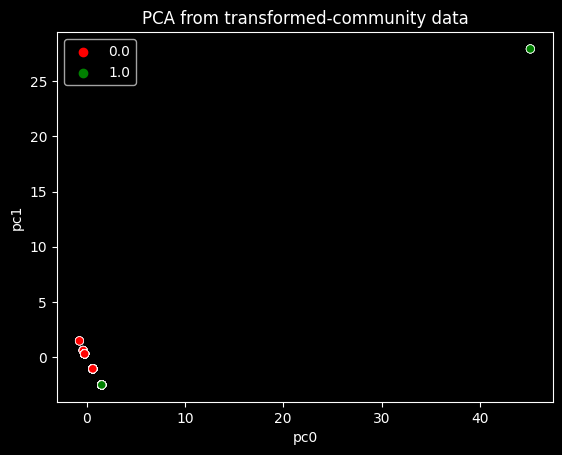

In [ ]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))
commu_pca.shape

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 20.3 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

In [ ]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binnedd cols are:
cat_cols = train_binned.columns[:-1]
columnNames = cat_cols

# 18.2 Communities will be created as per this algo:
#nx.algorithms.community.girvan_newman(G)
algolist = [nx.community.label_propagation_communities]

# 18.3 Graph files are within:
pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/allmodels/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  _,df_tr = transformBinnedDF2CommunitiesAll(pathToGraphFolder,train_binned,algo)
  _,df_te = transformBinnedDF2CommunitiesAll(pathToGraphFolder,test_binned,algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

In [ ]:
fg_tr[0].shape

(11276, 280)

In [ ]:
# Remove constant cols
# https://stackoverflow.com/a/20210048
fg_tr[0] = fg_tr[0].loc[:, (fg_tr[0] != fg_tr[0].iloc[0]).any()]
fg_te[0] = fg_te[0][fg_tr[0].columns]

In [ ]:
fg_tr[0].shape

(11276, 109)

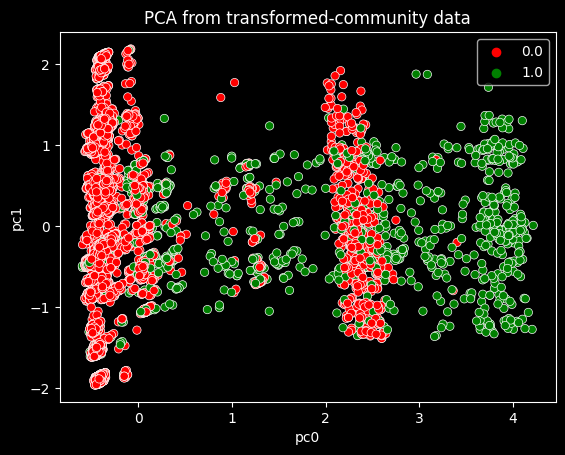

In [ ]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
xx = si.fit_transform(fg_tr[0][fe_11[:15]])

# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(xx))
commu_pca.shape

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 20.3 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

In [ ]:
# 19.0 Modeling with transformed train/test data with impt features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 700,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0][fe_11[:15]]
test_X = fg_te[0][fe_11[:15]]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[08:16:15] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[08:16:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.94088	validation_1-auc:0.94297
[08:16:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.94100	validation_1-auc:0.94252
[08:16:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.94131	validation_1-auc:0.94258
[08:16:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.94130	validation_1-auc:0.94265
[08:16:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.96194	validation_1-auc:0.95724
[08:16:17] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned node

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 10.0 Get feature importance:

fe_11, fe_00, fee = utils.xgImptFeatures(model_trans_commu,  fg_tr[0].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fee.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_11[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_00[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
SkewIP_projected_ExKurtosisIP_p_SkewIP.gml,0.379014
MIP_projected_StdDevIP_p_SkewIP.gml,0.221646
SkewIP_projected_MIP_p_StdDevIP.gml,0.109291
MeanDMSNR_projected_ExKurtosisIP_p_MeanDMSNR.gml,0.094772
MeanDMSNR_projected_MIP_p_ExKurtosisDMSNR.gml,0.044740




== Column-list whose feat impt >0 =======



['SkewIP_projected_ExKurtosisIP_p_SkewIP.gml',
 'MIP_projected_StdDevIP_p_SkewIP.gml',
 'SkewIP_projected_MIP_p_StdDevIP.gml',
 'MeanDMSNR_projected_ExKurtosisIP_p_MeanDMSNR.gml',
 'MeanDMSNR_projected_MIP_p_ExKurtosisDMSNR.gml']



===Column-list whose feat impt is 0 =======



['ExKurtosisDMSNR_projected_MeanDMSNR.gml',
 'MIP_projected_MIP_p_SkewIP.gml',
 'ExKurtosisIP_projected_SkewIP_p_SkewDMSNR.gml',
 'ExKurtosisIP_projected_SkewIP_p_StdDevDMSNR.gml',
 'ExKurtosisIP_projected_StdDevIP_p_ExKurtosisIP.gml']